In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # alphabet
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Examples
Test with initial 5 words

REFERENCE: https://www.youtube.com/watch?v=TCH_1BHY58I

In [137]:
# build the dataset
block_size = 3 # context length: how many chars do we take to predict the next one
X, Y = [], []  # X is input, Y is label
for w in words[:5]:
    print(w)
    context = [0] * block_size # initialize context by padding with 0
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop & append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ----> e
..e ----> m
.em ----> m
emm ----> a
mma ----> .
olivia
... ----> o
..o ----> l
.ol ----> i
oli ----> v
liv ----> i
ivi ----> a
via ----> .
ava
... ----> a
..a ----> v
.av ----> a
ava ----> .
isabella
... ----> i
..i ----> s
.is ----> a
isa ----> b
sab ----> e
abe ----> l
bel ----> l
ell ----> a
lla ----> .
sophia
... ----> s
..s ----> o
.so ----> p
sop ----> h
oph ----> i
phi ----> a
hia ----> .


In [138]:
C = torch.randn((27,2)) # every 27 characters has 2 features embedded
C.shape

torch.Size([27, 2])

In [141]:
X.shape

torch.Size([32, 3])

In [142]:
emb = C[X]
emb.shape # 32 rows of input, each row has 3 char, each char is represented by 2 features

torch.Size([32, 3, 2])

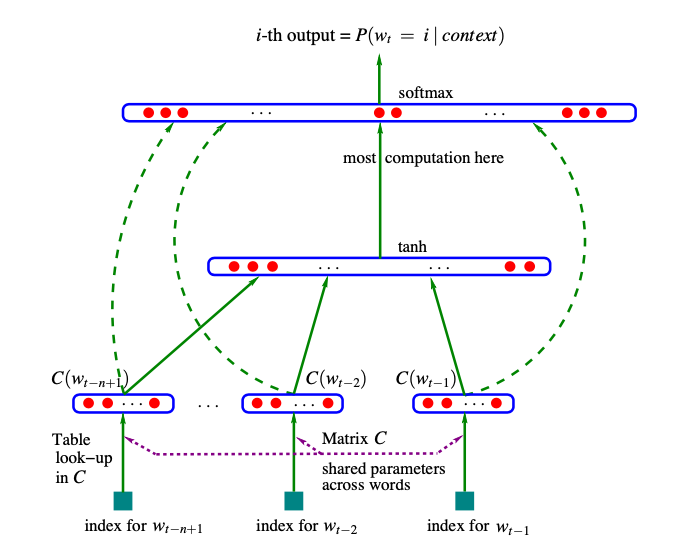

### Hidden Layer
tanh as activation function

In [143]:
# Construct the hidden layer
W1 = torch.randn((6, 100)) # weights with no. of inputs = 2 features embedded * 3 input characters = 6; 100 neurons
b1 = torch.randn(100) # biases

In [144]:
W1.shape

torch.Size([6, 100])

- The idea is to perform `emb @ W1 + b1`
- However, `emb.shape` = `torch.Size([32, 3, 2])` and `W1.shape` = `torch.Size([6, 100])`, so unable to multiple
- Hence, `emb` needs to be re-shaped to `torch.Size([32, 6])` --> called

In [145]:
emb[:5]

tensor([[[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]],

        [[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [-1.1304,  1.0066]],

        [[ 2.0425,  0.8423],
         [-1.1304,  1.0066],
         [ 1.3725, -1.2475]],

        [[-1.1304,  1.0066],
         [ 1.3725, -1.2475],
         [ 1.3725, -1.2475]],

        [[ 1.3725, -1.2475],
         [ 1.3725, -1.2475],
         [-0.0896,  0.5406]]])

In [146]:
# Method 1 to re-shape emb is to concatenate along the direction 1 (horizontally) 
# emb[:, 0, :] for the 1st char, emb[:, 1, :] for the 2nd char, and emb[:, 2, :] for the 3rd char
# basically convert 32 x 3 x 2 to 32 x (6) --> put 3x2 table into 1x6 table
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)[:3] # too specific, not able to generalize

tensor([[ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423, -1.1304,  1.0066],
        [ 2.0425,  0.8423, -1.1304,  1.0066,  1.3725, -1.2475]])

In [147]:
# Example of touch.unbind along the horizontal direction
torch.unbind(emb[4:7], 1)

(tensor([[ 1.3725, -1.2475],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]]),
 tensor([[ 1.3725, -1.2475],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]]),
 tensor([[-0.0896,  0.5406],
         [ 2.0425,  0.8423],
         [ 0.8501, -0.0449]]))

In [148]:
emb[4:7]

tensor([[[ 1.3725, -1.2475],
         [ 1.3725, -1.2475],
         [-0.0896,  0.5406]],

        [[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [ 2.0425,  0.8423]],

        [[ 2.0425,  0.8423],
         [ 2.0425,  0.8423],
         [ 0.8501, -0.0449]]])

In [149]:
# torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)[:3] # too specific, not able to generalize

In [150]:
# torch.cat(torch.unbind(emb, dim=1), dim=1)[:3] # more generalized, but inefficient as it creates new tensor > new memory space

In [151]:
# Method 2 to re-shape emb by re-present to another shape using view() method
emb.view(32,6)

tensor([[ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423, -1.1304,  1.0066],
        [ 2.0425,  0.8423, -1.1304,  1.0066,  1.3725, -1.2475],
        [-1.1304,  1.0066,  1.3725, -1.2475,  1.3725, -1.2475],
        [ 1.3725, -1.2475,  1.3725, -1.2475, -0.0896,  0.5406],
        [ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423,  0.8501, -0.0449],
        [ 2.0425,  0.8423,  0.8501, -0.0449, -0.3361,  1.2816],
        [ 0.8501, -0.0449, -0.3361,  1.2816,  1.5350, -2.3814],
        [-0.3361,  1.2816,  1.5350, -2.3814,  0.8911, -1.9873],
        [ 1.5350, -2.3814,  0.8911, -1.9873,  1.5350, -2.3814],
        [ 0.8911, -1.9873,  1.5350, -2.3814, -0.0896,  0.5406],
        [ 2.0425,  0.8423,  2.0425,  0.8423,  2.0425,  0.8423],
        [ 2.0425,  0.8423,  2.0425,  0.8423, -0.0896,  0.5406],
        [ 2.0425,  0.8423, -0.0896,  0.5406,  0.8911, -1.9873],
        [-0.0896,  0.5406,  0.8911, -1.9

In [152]:
emb.view(emb.shape[0],6) @ W1 + b1

tensor([[ 3.3140, -3.8671, -0.6250,  ..., -3.2905, -1.1911, -4.1697],
        [ 3.4037, -3.2638,  3.1368,  ..., -3.4133,  0.2480, -4.2026],
        [-4.1245, -8.0483,  0.6369,  ..., -3.0060, -1.2730,  3.5522],
        ...,
        [ 1.1871, -4.5686,  1.3899,  ..., -2.0376,  0.8434,  3.1872],
        [-0.2614, -1.4828, -1.3138,  ..., -1.3635, -2.7280,  2.9878],
        [10.1638,  0.1614,  0.9221,  ..., -2.0136,  2.5010, -1.6219]])

In [153]:
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1) # inputs @ weights + bias, then apply activation function tanh
# use of tanh will keep all the outputs between -1 and 1

In [154]:
h

tensor([[ 0.9974, -0.9991, -0.5546,  ..., -0.9972, -0.8309, -0.9995],
        [ 0.9978, -0.9971,  0.9962,  ..., -0.9978,  0.2430, -0.9996],
        [-0.9995, -1.0000,  0.5628,  ..., -0.9951, -0.8546,  0.9984],
        ...,
        [ 0.8297, -0.9998,  0.8832,  ..., -0.9666,  0.6876,  0.9966],
        [-0.2556, -0.9020, -0.8652,  ..., -0.8772, -0.9915,  0.9949],
        [ 1.0000,  0.1600,  0.7269,  ..., -0.9650,  0.9866, -0.9249]])

### Final layer
softmax

In [155]:
# Construct the final layer
W2 = torch.randn((100, 27)) # input of 100 to match with output from hidden layer, output of 27 for 27 possible characters, 
b2 = torch.randn(27) # biases

In [156]:
logits = h @ W2 + b2

In [157]:
logits.shape

torch.Size([32, 27])

In [158]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
prob.shape

torch.Size([32, 27])

In [159]:
# for each input element in X consisting of 3 chars, the probablity of 27 chars appear next is in prob
# to plug out the prob of char stored in Y (label), given the input X
prob[torch.arange(32),Y] # prob[0,Y[0]] === prob of input as X[0] and output as Y[0]

tensor([6.2005e-12, 1.9981e-03, 7.2258e-01, 1.3705e-05, 5.5161e-05, 8.0822e-13,
        1.7507e-01, 3.6645e-08, 7.7354e-08, 1.3147e-03, 1.1715e-09, 4.7185e-09,
        4.0241e-10, 5.8399e-03, 8.0691e-03, 5.1777e-11, 9.2270e-06, 5.8876e-10,
        3.1717e-07, 1.1788e-15, 3.5358e-07, 8.8870e-04, 9.1886e-04, 3.8306e-04,
        6.8576e-17, 4.6000e-14, 3.0683e-10, 4.2647e-11, 2.3882e-04, 1.8950e-13,
        7.5745e-07, 1.1082e-08])

In [160]:
# calculate loss function by negative log likelihood
loss = -prob[torch.arange(32),Y].log().mean().item()
loss

16.273956298828125

### Summary

In [161]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [162]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100)) # weights with no. of inputs = 2 features embedded * 3 input characters = 6; 100 neurons
b1 = torch.randn(100) # biases
W2 = torch.randn((100, 27)) # input of 100 to match with output from hidden layer, output of 27 for 27 possible characters, 
b2 = torch.randn(27) # biases
parameters = [C, W1, b1, W2, b2]

In [163]:
sum(p.nelement() for p in parameters) # no. of parameters in total

3481

In [167]:
for p in parameters:
    p.requires_grad = True

In [170]:
for _ in range(1000):
    # forward pass
    emb = C[X] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y) # similar to the above 3 codes. more efficient in both forward & backward pass
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

# currently overfitting of the first 32 examples with so many parameters --> easy to overfit

0.25524842739105225


## Full codes

In [216]:
# function to build data set with train/dev/test splits
def build_dataset(words):
    block_size = 3 # context length: how many chars do we take to predict the next one
    X, Y = [], []  # X is input, Y is label
    for w in words:
        context = [0] * block_size # initialize context by padding with 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [217]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [218]:
# Build the neuron layers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g) # embedding
W1 = torch.randn((6, 100)) # weights with no. of inputs = 2 features embedded * 3 input characters = 6; 100 neurons
b1 = torch.randn(100) # biases
W2 = torch.randn((100, 27)) # input of 100 to match with output from hidden layer, output of 27 for 27 possible characters, 
b2 = torch.randn(27) # biases
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # no. of parameters in total

3481

In [219]:
# Set grad for parameters
for p in parameters:
    p.requires_grad = True

In [210]:
lre = torch.linspace(-3,0,1000) # exponent
lr = 10**lre # learning rate varies between 0.001 and 1

In [228]:
# losses = []
for i in range(30000):
    # mini batch construct - to save time
    ix = torch.randint(0, Xtr.shape[0], (32,)) # pick only 32 samples from input X

    # forward pass
    emb = C[Xtr[ix]] # (32,3,2)
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 # initial lr
    lr_decay = 0.01 # after initial lr plataeu --> learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # # track stats
    # losses.append(loss.item())
print(loss.item())     

1.8636903762817383


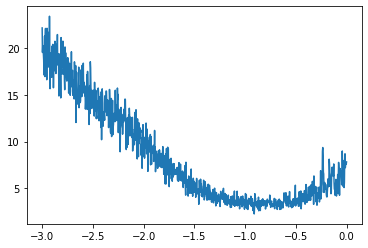

In [206]:
# plt.plot(lre, losses) # best learning rate is at the minimum i.e., lr = 10**(-1) = 0.1

In [229]:
# Actual training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss_train = F.cross_entropy(logits, Ytr)
loss_train.item()

2.3214752674102783

In [230]:
# Actual dev loss
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss_dev = F.cross_entropy(logits, Ydev)
loss_dev.item()

2.3255441188812256

`Note`:
- training split, dev/validation split, testing split: 80% (optimize parameters), 10% (hyperparameter tuning), 10% (evaluate the model at the very end)
- train loss and dev loss is about equal --> not overfitting but underfitting
- underfitting typically means that our network is very tiny, and we expect to improve the performance by scaling up the size of the NN